In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.font_manager as fm
from matplotlib import rc

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['font.family']='NanumGothic'
%matplotlib inline 

pd.set_option('display.max_columns', None)

In [17]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [3]:
user_loan_train = pd.read_csv("./사용데이터/user_loan_train.csv", encoding = 'cp949')
user_loan_target = pd.read_csv("./사용데이터/user_loan_target.csv", encoding = 'cp949')
cluster_info = pd.read_csv("./사용데이터/cluster_result.csv", encoding = 'cp949')
bank_cluster_info = pd.read_csv("./사용데이터/bank_cluster_result.csv", encoding = 'cp949')
print(1)

user_loan_train = pd.merge(user_loan_train,cluster_info, left_on = '상품번호', right_on = '상품번호', how = 'inner')
user_loan_target = pd.merge(user_loan_target,cluster_info, left_on = '상품번호', right_on = '상품번호', how = 'inner')
print(2)

user_loan_train = pd.merge(user_loan_train,bank_cluster_info, left_on = '금융사번호', right_on = '금융사번호', how = 'inner')
user_loan_target = pd.merge(user_loan_target,bank_cluster_info, left_on = '금융사번호', right_on = '금융사번호', how = 'inner')
print(3)

1
2
3


### 추천 상품 수 추가

In [4]:
count_df1 = user_loan_train[["신청서번호","월"]]
count_df2 = count_df1.groupby("신청서번호").count().reset_index()
count_df2.rename(columns = {"월": "추천상품수"}, inplace = True)
count_df2 = pd.merge(count_df1, count_df2, how = "left", left_on = "신청서번호", right_on = "신청서번호")
user_loan_train["추천상품수"]= count_df2["추천상품수"]

### 최소금리여부 추가
* 추천된 금리중 최소인가를 판단하는 라벨을 넣는다.

In [5]:
ir_df = user_loan_train[["신청서번호","승인금리"]]
ir_min_df=pd.DataFrame(ir_df.groupby("신청서번호").min()).reset_index()
ir_min_df.rename(columns = {"승인금리":"승인금리최소"}, inplace = True)
ir_min_df = pd.merge(ir_df, ir_min_df, how = "left", left_on = "신청서번호", right_on = "신청서번호")
ir_min_df["최소금리여부"] = ir_min_df["승인금리"] == ir_min_df["승인금리최소"]
ir_min_df["최소금리여부"].replace({True:1, False :0}, inplace = True)
user_loan_train["최소금리여부"] = ir_min_df["최소금리여부"]

### 최대한도 여부

In [6]:
lm_df = user_loan_train[["신청서번호","승인한도"]]
lm_max_df=pd.DataFrame(lm_df.groupby("신청서번호").max()).reset_index()
lm_max_df.rename(columns = {"승인한도":"승인한도최대"}, inplace = True)
lm_max_df = pd.merge(lm_df, lm_max_df, how = "left", left_on = "신청서번호", right_on = "신청서번호")
lm_max_df["최대한도여부"] = lm_max_df["승인한도"] == lm_max_df["승인한도최대"]
lm_max_df["최대한도여부"].replace({True:1, False :0}, inplace = True)
user_loan_train["최대한도여부"] = lm_max_df["최대한도여부"]

In [64]:
user_loan_train["상품번호"]

0           216
1           216
2           216
3           216
4           216
           ... 
10264381    238
10264382    238
10264383    238
10264384    238
10264385    238
Name: 상품번호, Length: 10264386, dtype: int64

## Clustering 준비

In [94]:
df_positive = user_loan_train[user_loan_train["신청여부(타겟)"]==1]

In [95]:
clus_pd = df_positive[["상품번호","추천상품수","승인금리","승인한도","한도조회당시유저신용점수","대출희망금액"]]

In [96]:
df1 = clus_pd.groupby(by=["상품번호"], as_index = False).mean()

In [97]:
df1

,상품번호,추천상품수,승인금리,승인한도,한도조회당시유저신용점수,대출희망금액
0,1,11.724138,11.692909,2.961429e+07,688.508931,2.948888e+07
1,5,4.111747,17.546966,1.079101e+07,636.206627,2.401879e+07
2,7,11.474012,13.521816,3.085944e+07,628.205108,3.871193e+07
3,8,9.341369,15.454098,1.222372e+07,670.344601,2.887271e+07
4,12,9.841600,13.828000,1.903680e+07,728.867421,1.850560e+07
...,...,...,...,...,...,...
160,265,17.453298,8.315375,2.366852e+07,740.072080,2.853559e+07
161,266,21.306693,12.492308,3.056943e+07,636.690490,2.680919e+07
162,267,20.685819,12.355746,2.792421e+07,647.155118,3.035513e+07
163,268,31.664141,8.321775,2.921652e+07,750.738745,3.849896e+07


In [98]:
cc1 = df1.iloc[:,1:]

In [99]:
sc1 = StandardScaler()
cc1_scaled = sc1.fit_transform(cc1)

In [100]:
cc1_scaled = pd.DataFrame(cc1_scaled, columns = cc1.columns)

In [101]:
wcss = []
iters = 0

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(cc1_scaled)
    
    name = "cluster" + str(i)
    
    pred = kmeans.predict(cc1_scaled)    
    
    cc1_scaled[name] = pred
    
    wcss.append(kmeans.inertia_)
    print(iters)
    iters+=1

C:\Users\jbhyu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\jbhyu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


0
1


C:\Users\jbhyu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\jbhyu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


2
3


C:\Users\jbhyu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\jbhyu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


4
5


C:\Users\jbhyu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\jbhyu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


6
7


C:\Users\jbhyu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\jbhyu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


8
9


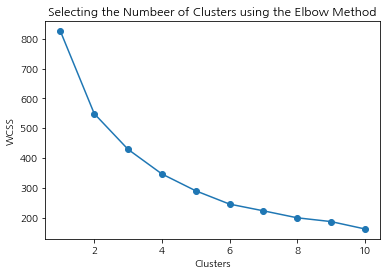

In [102]:
plt.plot(range(1, 11), wcss, marker = 'o')
plt.title('Selecting the Numbeer of Clusters using the Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.show()

In [103]:
def clust_paint(col, clus_name):
    col_ = col+[clus_name]
    print(col_)
    cc_test = cc1_scaled[col_]
    display(cc_test.groupby(clus_name).count())
    pca = PCA(n_components =2)
    pca.fit(cc_test)
    x_pca = pca.transform(cc_test)
    pca_df = pd.DataFrame(x_pca)
    pca_df[clus_name] = cc_test[clus_name]
    
    for i in sorted(pca_df[clus_name].unique()):
        tmp = pca_df.loc[pca_df[clus_name] == i] #해당하는 클러스터 번호일 때 그림을 그리고, for문 실행하며 위에 덧그림 
        plt.scatter(tmp[0], tmp[1])
        plt.legend(sorted(pca_df[clus_name].unique()))
    plt.show()

In [104]:
col = ["추천상품수","승인금리","승인한도","한도조회당시유저신용점수","대출희망금액"]
clus_name = ["cluster4","cluster5","cluster6","cluster7"]

['추천상품수', '승인금리', '승인한도', '한도조회당시유저신용점수', '대출희망금액', 'cluster4']


,추천상품수,승인금리,승인한도,한도조회당시유저신용점수,대출희망금액
cluster4,,,,,
0,70,70,70,70,70
1,31,31,31,31,31
2,63,63,63,63,63
3,1,1,1,1,1


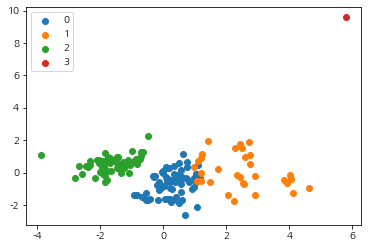

['추천상품수', '승인금리', '승인한도', '한도조회당시유저신용점수', '대출희망금액', 'cluster5']


,추천상품수,승인금리,승인한도,한도조회당시유저신용점수,대출희망금액
cluster5,,,,,
0,20,20,20,20,20
1,63,63,63,63,63
2,31,31,31,31,31
3,1,1,1,1,1
4,50,50,50,50,50


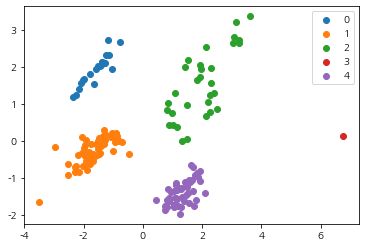

['추천상품수', '승인금리', '승인한도', '한도조회당시유저신용점수', '대출희망금액', 'cluster6']


,추천상품수,승인금리,승인한도,한도조회당시유저신용점수,대출희망금액
cluster6,,,,,
0,63,63,63,63,63
1,16,16,16,16,16
2,20,20,20,20,20
3,50,50,50,50,50
4,1,1,1,1,1
5,15,15,15,15,15


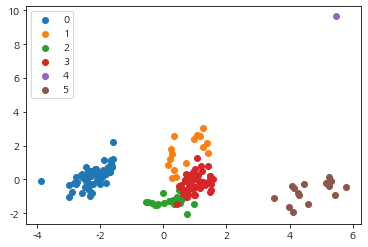

['추천상품수', '승인금리', '승인한도', '한도조회당시유저신용점수', '대출희망금액', 'cluster7']


,추천상품수,승인금리,승인한도,한도조회당시유저신용점수,대출희망금액
cluster7,,,,,
0,50,50,50,50,50
1,63,63,63,63,63
2,15,15,15,15,15
3,20,20,20,20,20
4,14,14,14,14,14
5,2,2,2,2,2
6,1,1,1,1,1


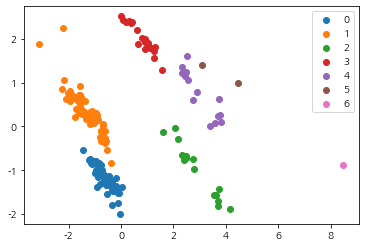

In [105]:
for name in clus_name:
    clust_paint(col,name)

In [106]:
df1["상품군집"] = cc1_scaled["cluster5"]

In [107]:
result_pd = df1.groupby("상품군집").mean().reset_index()
result_pd = result_pd.drop("상품번호", axis=1)
display(result_pd)

,상품군집,추천상품수,승인금리,승인한도,한도조회당시유저신용점수,대출희망금액
0,0,12.328510,7.736904,1.129410e+07,642.776889,1.651452e+07
1,1,6.923687,16.447202,1.594592e+07,623.001748,2.099337e+07
2,2,27.625415,9.188338,3.378016e+07,778.218138,4.060585e+07
3,3,13.133858,8.605512,2.600630e+08,700.561680,9.016535e+07
4,4,13.260604,13.386782,2.462101e+07,687.034124,2.907305e+07


In [108]:
df1

,상품번호,추천상품수,승인금리,승인한도,한도조회당시유저신용점수,대출희망금액,상품군집
0,1,11.724138,11.692909,2.961429e+07,688.508931,2.948888e+07,4
1,5,4.111747,17.546966,1.079101e+07,636.206627,2.401879e+07,1
2,7,11.474012,13.521816,3.085944e+07,628.205108,3.871193e+07,4
3,8,9.341369,15.454098,1.222372e+07,670.344601,2.887271e+07,1
4,12,9.841600,13.828000,1.903680e+07,728.867421,1.850560e+07,4
...,...,...,...,...,...,...,...
160,265,17.453298,8.315375,2.366852e+07,740.072080,2.853559e+07,2
161,266,21.306693,12.492308,3.056943e+07,636.690490,2.680919e+07,4
162,267,20.685819,12.355746,2.792421e+07,647.155118,3.035513e+07,4
163,268,31.664141,8.321775,2.921652e+07,750.738745,3.849896e+07,2


In [115]:
product_info = {}
for i in sorted(set(df1["상품군집"].values)):
    label = "상품군집{}".format(i)
    product_info[label]=df1[df1["상품군집"]==i]["상품번호"].values

In [116]:
product_info

{'상품군집0': array([ 47,  48,  75,  78, 103, 127, 134, 136, 148, 164, 184, 187, 189,
        190, 195, 225, 229, 251, 257, 261], dtype=int64),
 '상품군집1': array([  5,   8,  16,  19,  29,  36,  38,  39,  43,  51,  55,  56,  57,
         70,  79,  81,  82,  85,  86,  93,  98, 100, 107, 110, 113, 118,
        123, 124, 126, 139, 149, 150, 152, 157, 159, 161, 162, 168, 169,
        174, 186, 191, 192, 197, 204, 205, 206, 215, 216, 217, 220, 221,
        222, 223, 226, 231, 235, 239, 243, 248, 252, 263, 264], dtype=int64),
 '상품군집2': array([ 22,  26,  31,  35,  42,  46,  58,  59,  60,  63,  80,  92,  94,
         96, 105, 119, 131, 144, 170, 181, 183, 185, 188, 234, 238, 246,
        250, 259, 265, 268, 270], dtype=int64),
 '상품군집3': array([244], dtype=int64),
 '상품군집4': array([  1,   7,  12,  15,  20,  24,  25,  30,  40,  49,  61,  62,  65,
         67,  68,  71,  90,  91, 108, 111, 114, 121, 128, 129, 137, 138,
        140, 141, 142, 146, 147, 163, 171, 175, 176, 194, 196, 200, 224,
        227, 

## 서비스에 대해서
**가정: 여러번 대출된 상품은 대출이 잘 될 것이다.**

**타겟값이 1인 애들의 정보를 이용하여 상품 군집을 만들었다.**

**특정 고객의 추천상품수, 승인금리, 승인한도, 한도조회당시 유저신용점수, 대출희망금액을 받으면 어떤 군집에 속하는지 판단하고(거리를 이용해서 최소인 군집선정) 그 군집의 상품을 우선적으로 추천한다. 또 만약 추천되지 않았다면 나가기 전에 이런 상품도 있는데 한번 보실래요?라는 문구를 통해 대출 성공률을 높인다.**
